In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import pdb
import polyphase 
import pickle

from scipy.spatial.distance import euclidean, squareform
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

In [3]:
dirname = '../data/hamming/pm6y6_crop90'
distmats = dirname + '/distance.pkl'

with open(distmats, 'rb') as handle:
    out = pickle.load(handle)

sys_df = out['df'].reset_index(drop=True)
sm = sys_df['delta_SM'][0]
polymer = sys_df['delta_polymer'][0]
M = out['M']
deltas = np.asarray(sys_df['delta_solv'].to_list())

In [7]:
from scipy.spatial.distance import pdist, euclidean, squareform

def ssp_kernel(di, dj,r=3.4, norm='l2'):
    dmu = 0.5*(np.asarray(sm)+np.asarray(polymer))
    d = euclidean(sm,polymer)
    gamma = 2*r + d
    
    xi = np.asarray(di)-dmu
    xj = np.asarray(dj)-dmu
    
    if norm=='l2': 
        dij = np.sqrt(np.abs(np.dot(xi,xj)))
    elif norm=='euclidean':
        dij = euclidean(xi,xj) # this is equal to d(di,dj)
    elif norm=='scale':
        ab = np.linalg.norm(xi)/np.linalg.norm(xj)
        ba = np.linalg.norm(xj)/np.linalg.norm(xi)
        dij = 0.5*(ab+ba)
    else:
        raise Exception('norm {} is not recognized'.format(norm))
        
    similarity = np.exp(-(dij**2)/(2* gamma**2))

    return similarity

d = lambda x1,x2 : ssp_kernel(x1, x2,r=3.4, norm='scale')
K_ssp = squareform(pdist(deltas, d))
np.fill_diagonal(K_ssp, 1)
K_pd = np.exp(- M ** 2 / (2. * M.std() ** 2))

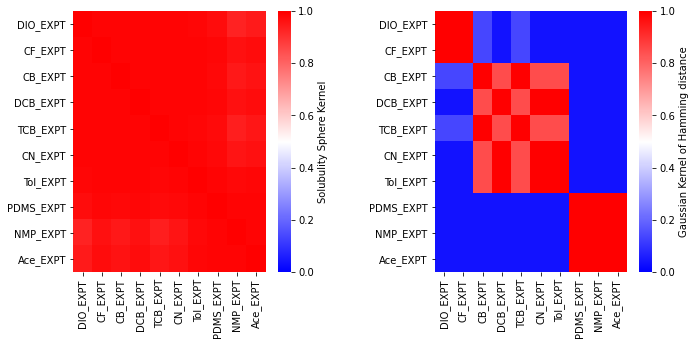

In [8]:
fig, axs = plt.subplots(1,2,figsize=(10.8, 4.8))
fig.subplots_adjust(left=0.075, right=0.85, wspace=0.5)
names = sys_df[86:]['solvent'].to_list()
sns.heatmap(K_ssp[86:,86:],ax = axs[0],xticklabels=names, yticklabels = names,
            cbar_kws={'label':'Solubulity Sphere Kernel'},cmap='bwr',vmin=0,vmax=1)
sns.heatmap(K_pd[86:,86:],ax = axs[1],xticklabels=names, yticklabels = names,
           cbar_kws={'label':'Gaussian Kernel of Hamming distance'},cmap='bwr',vmin=0,vmax=1)

plt.show()

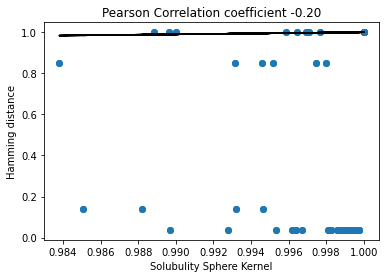

In [6]:
x = K_ssp[86:,86:].flatten()
y = K_pd[86:,86:].flatten()
r,p = pearsonr(x,y)
fig, ax = plt.subplots()
ax.scatter(x,y)
ax.plot(x,x,color='k')
ax.set_xlabel('Solubulity Sphere Kernel')
ax.set_ylabel('Hamming distance')
ax.set_title('Pearson Correlation coefficient {:.2f}'.format(r))
plt.show()